## Задача

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

## Решение

Импортируем все необходимые библиотеки. 

In [1]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from warnings import filterwarnings 
filterwarnings('ignore')
from scipy.optimize import minimize # вместо градиентного спуска
from sklearn.metrics import mean_squared_error

Импортируем датасет. 

In [2]:
data = pd.read_csv('/Users/valeriaastahova/Desktop/Машинное обучение Нетология/Датасеты/Временные ряды/international-airline-passengers.csv')

In [3]:
vr = data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']

Пропишем функции теста на стационарность. 

In [4]:
def test_stationarity(timeseries): # функция, которая тестирует на стационарность
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'): # функция, которая рисует корреляцию и автокорреляцию
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


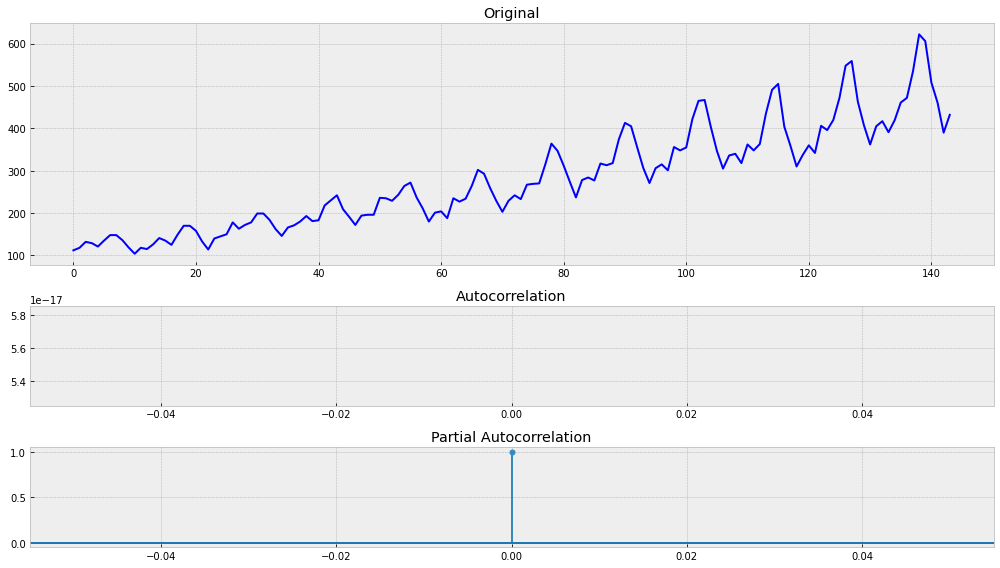

In [6]:
tsplot(vr)

Оставим этот ряд, как нестационарный. Создадим копию ряда, избавимся от возрастающей дисперсии,сезонности тренда. 

In [7]:
new_vr = vr.copy()

Results of Dickey-Fuller Test:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


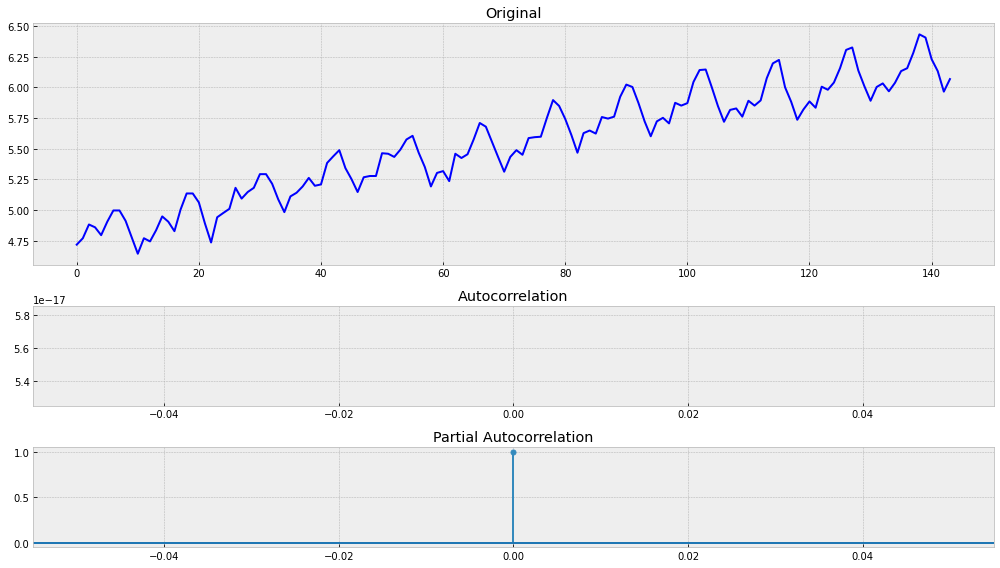

In [8]:
new_vr = boxcox(new_vr, 0)
tsplot(new_vr)

Results of Dickey-Fuller Test:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


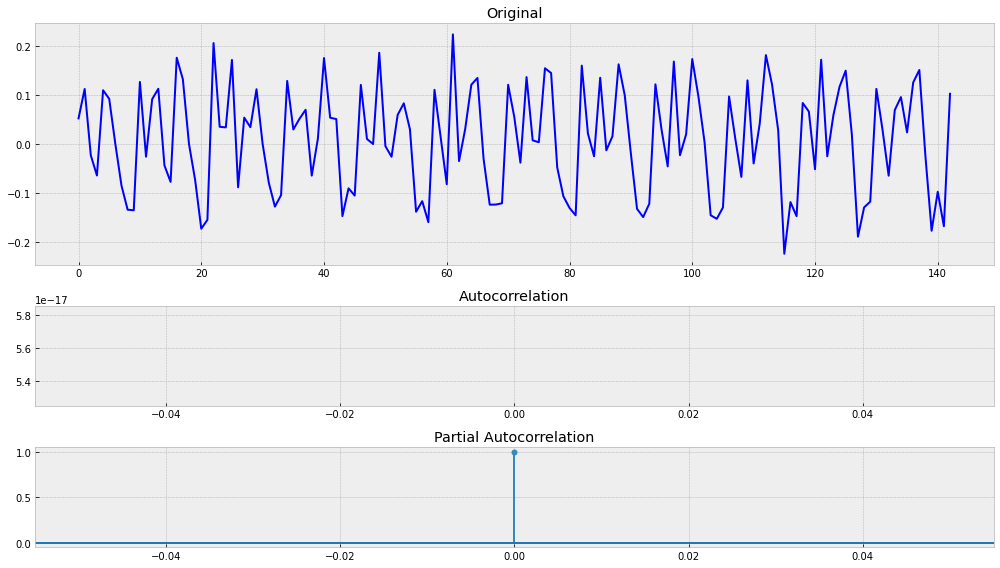

In [9]:
new_vr = np.diff(new_vr, 1)
tsplot(new_vr)

Results of Dickey-Fuller Test:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


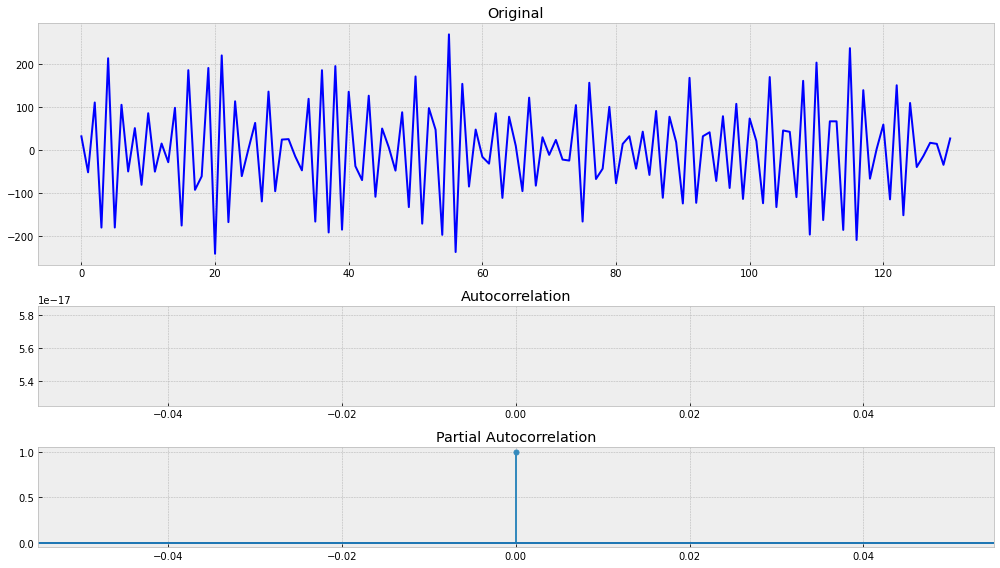

In [10]:
new_vr = np.diff(new_vr, 12)
tsplot(new_vr)

Эту вариацию ряда сохраним как стационарную. Приступим к приближению этих рядов моделями из класса МА. 

### Приближение рядов

#### Нестационарный ряд

Для работы с нестационарным рядом используем метод Хольт-Винтерса. Он хорошо работает с рядами, в которых присутсвует выраженная сезонность. 

In [11]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [12]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [13]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds): # функция тройного экспон. сглаживания
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i) # слен - длина сезона
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [14]:
def plot_tema(alpha, beta, gamma, ser=vr, ser_to_plot=vr, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Для подбора параметров используем кросс-валидацию. 

In [15]:
series = vr

In [16]:
len(series)

145

In [17]:
train, val = series[:100], series[100:]

In [18]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [19]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [20]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 469.87273101869295
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.93267624e-04, -1.53477231e-04, -7.01965064e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 14
   status: 0
  success: True
        x: array([0.9710645 , 0.07070909, 1.        ])


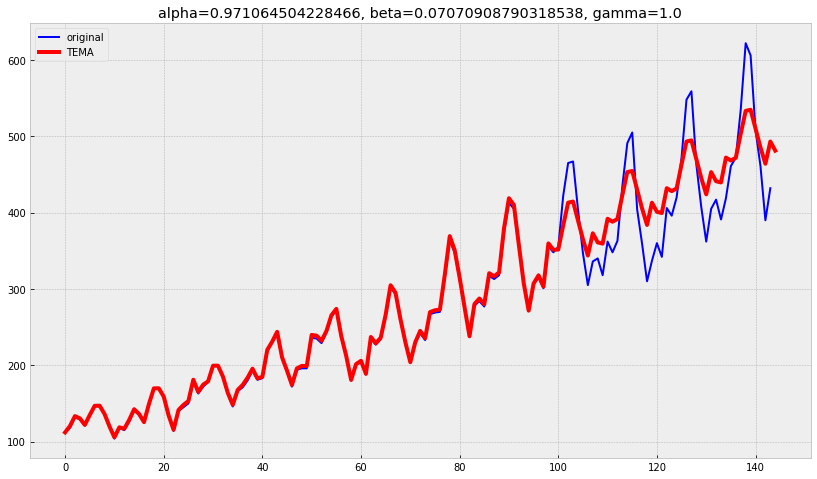

In [21]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Этот метод достаточно хорошо описал имеющийся ряд, но не очень хорошо справился с предсказанием. Попробуем несколько других методов оптимизации. 

In [22]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

In [23]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.18646385,  0.60123465, -0.09998702],
       [ 0.18646421,  0.60121245, -0.09999085],
       [ 0.18646342,  0.60118136, -0.09998155],
       [ 0.18644064,  0.60132709, -0.09999044]]), array([310.7137689 , 310.7137698 , 310.71377116, 310.7137715 ]))
           fun: 310.71376889682796
       message: 'Optimization terminated successfully.'
          nfev: 272
           nit: 149
        status: 0
       success: True
             x: array([ 0.18646385,  0.60123465, -0.09998702])


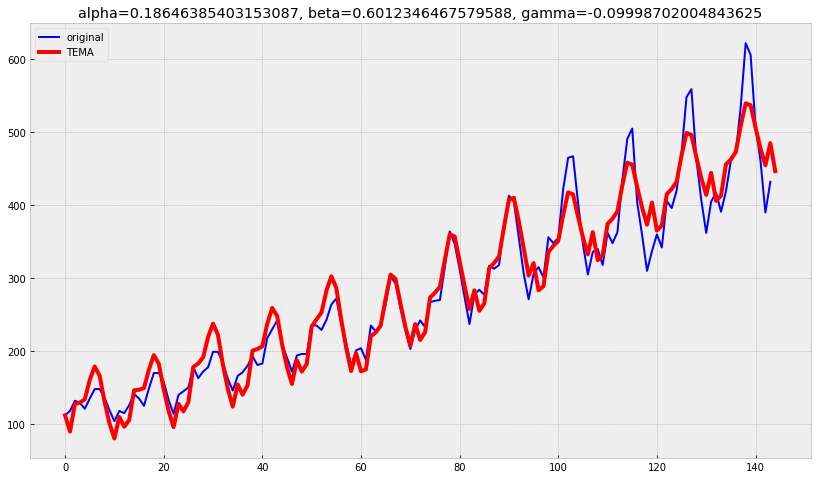

In [24]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

При оптимизации методом Nelder-Mead мы получаем худшее описание уже имеющегося ряда, но лучшее предсказание. При этом ни один из методов не учитывает в достаточной мере растущую дисперсию ряда. 

#### Стационарный ряд

Для работы со стационарным рядом будем использовать двойное экспоненциальное сглаживание, потому что мы уже избавились от сезонности, а значит, тройное экспоненциальное сглаживание нам не подходит. 

In [25]:
def double_ema(series, alpha, beta): # двойное экспоненциальное сглаживание (описание ряда)
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [26]:
def plot_dema(alpha, beta): # описание ряда
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [27]:
def plot_dema_pred(alpha, beta, ser=train, ser_to_plot=series, n_preds=24): # предсказание ряда
    dema = double_exponential_moving_average(ser, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [28]:
def double_exponential_moving_average(series, alpha, beta, n_preds): # предсказание ряда
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result) #series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

Для подбора параметров также используем кросс-валидацию. 

In [29]:
series = pd.Series(new_vr)

In [30]:
len(series)

132

In [31]:
series

0       31.902826
1      -51.949723
2      110.856450
3     -180.902579
4      214.012546
          ...    
127     16.812931
128     14.376503
129    -34.562392
130     26.949059
131           NaN
Length: 132, dtype: float64

In [32]:
train, val = series[:100], series[100:]

In [33]:
def mse_cross_val_2(X):
    alpha, beta= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = double_exponential_moving_average(train_split_ts, alpha, beta, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [34]:
opt = minimize(mse_cross_val_2, x0=[0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1)))

In [35]:
alpha_opt, beta_opt = opt.x
print(opt)

 final_simplex: (array([[0.14454159, 0.10759163],
       [0.144505  , 0.10759747],
       [0.14453405, 0.10759617]]), array([12562.92553808, 12562.92554122, 12562.92557683]))
           fun: 12562.9255380753
       message: 'Optimization terminated successfully.'
          nfev: 102
           nit: 55
        status: 0
       success: True
             x: array([0.14454159, 0.10759163])


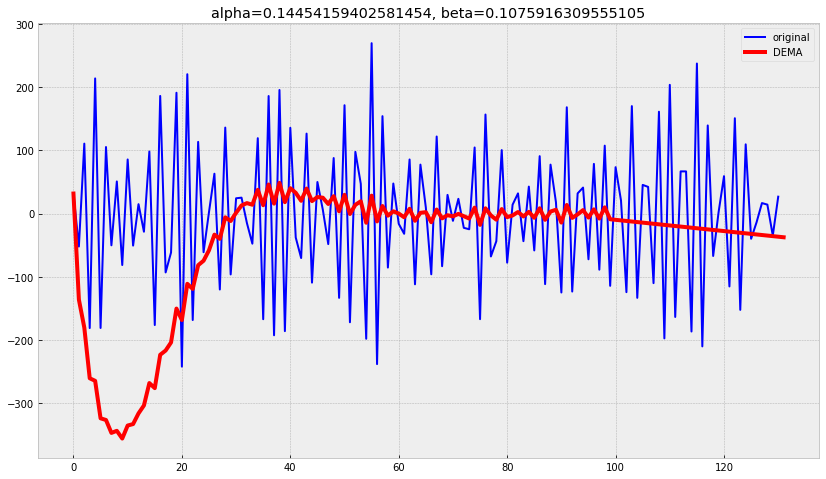

In [36]:
plot_dema_pred(alpha_opt, beta_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Попробуем ручной подбор параметров.

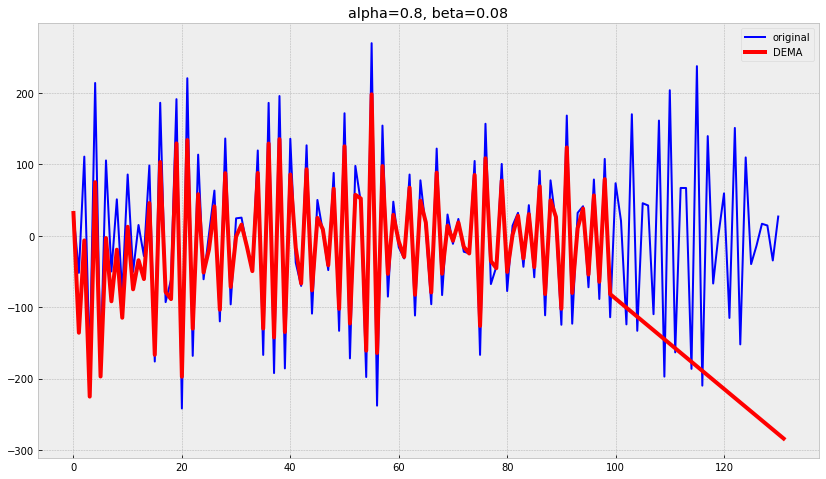

In [37]:
plot_dema_pred(0.8, 0.08, ser=train, ser_to_plot=series, n_preds=len(val))

Двойное экспоненциальное сглаживание может неплохо описывать ряд, но ужасно его предсказывает. Для эксперимента попробуем использовать тройное экспоненциальное сглаживание с этим рядом. 

In [38]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [39]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 6126.374976331208
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.36646291e-04, 3.23965296e+03, 8.81467713e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 10
   status: 0
  success: True
        x: array([0.06282394, 0.        , 0.        ])


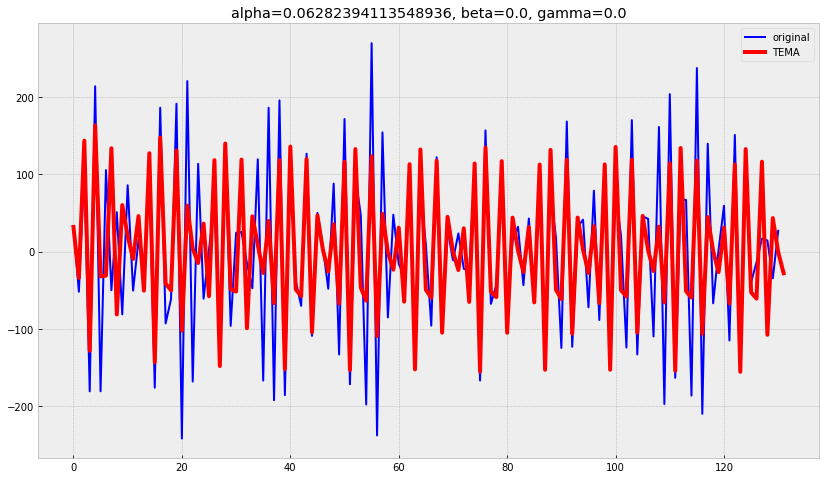

In [40]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Тройное экспоненциальное сглаживание на стационарном ряду работает тоже плохо. 